In [ ]:
import torch
from torch.testing import _compare_tensors_internal

import gc
import time
import random

def p(device, dtype, msg):
    def topKViaSort(x, k, dim):
        val, idx = x.sort(dim, True)
        return (val.narrow(dim, 0, k), idx.narrow(dim, 0, k))
    def run(func, reps=200):
        # warmup
        for _ in range(reps):
            func()
        
        torch.cuda.synchronize()
        start_t = time.time()
        
        for _ in range(reps):
            y = func()
        
        torch.cuda.synchronize()
        end_t = time.time()
        
        return (end_t - start_t) / reps
    
    print(torch.__version__)
    print('device:', device)
    
    ns = [1, 3, 10]
    bs = [int(1e4), int(5e4), int(1e5), int(5e5), int(1e6), int(5e6), int(1e7), int(5e7), int(1e8)] \
        + torch.randint(int(1e5), int(1e7), (50, )).tolist()
    ks = [1, 10, 50, 100, 500, 1000]
    
    sizes = []
    for n1 in ns:
        for n2 in ns:
            for b in bs:
                for k in ks:
                    sizes.append((n1, n2, b, k, -1))
                    sizes.append((n1, b, n2, k, 1))
                    sizes.append((b, n1, n2, k, 0))
    fn = f'{msg}-{device}-{dtype}.txt'
    print(fn)
    print(f'total {len(sizes)} sizes\n')
    
    t1 = time.time()

    with open(fn, 'w') as f:
        for size in sizes:
            try:
                torch.cuda.empty_cache()
                x = torch.randn(*size[:-2], device=device, dtype=dtype)

                t = run(lambda: torch.topk(x, k=size[-2], dim=size[-1]))
                t *= 1000
                f.write(f'{size} # {t}\n')

                y1 = torch.topk(x, k=size[-2], dim=size[-1])
                y2 = topKViaSort(x, k=size[-2], dim=size[-1])

                # values should be exactly equal
                a, b = _compare_tensors_internal(y1.values, y2[0], atol=0, rtol=0, equal_nan=False)
                assert a, b


                if not y1.indices.eq(y2[1]).all():
                    vals = x.gather(index=y1.indices, dim=size[-1])
                    a, b = _compare_tensors_internal(vals, y2[0], atol=0, rtol=0, equal_nan=False)
                    assert a, b
                    
            except RuntimeError as e:
                if str(e).startswith('CUDA out of memory'):
                    print(f'{size} OOM')
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise        
                
    t2 = time.time()
    print(f'total time {t2 - t1}')

In [ ]:
p('cuda', torch.float, 'before')
p('cuda', torch.half, 'before')

In [ ]:
p('cuda', torch.float, 'after')
p('cuda', torch.half, 'after')

In [6]:
import seaborn as sns

def compare(name: str):
    def parse(_name: str):
        with open(_name, 'r') as f:
            ln = f.readlines()
            
        d = {}
        for line in ln:
            idx = line.index('#')
            key = line[:idx]
            val = float(line[idx+1:])
            
            d[key] = val
        
        return d
    
    print(name)
    before_name = 'before-' + name
    after_name = 'after-' + name
    
    d_before = parse(before_name)
    d_after = parse(after_name)
    diff = []
    
    for key in d_before:
        assert key in d_after
        
        tb = d_before[key]
        ta = d_after[key]
        
        diff.append((ta-tb)/tb)
    
    sns.distplot(diff)

cuda-torch.float32.txt


/home/xwang/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


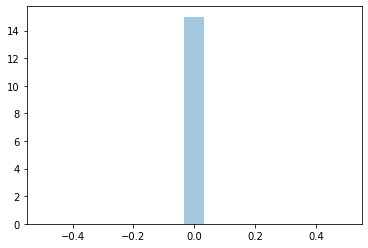

In [8]:
compare('cuda-torch.float32.txt')
# compare('cuda-torch.float16.txt')